# Calcul des Vitesses du Son Acoustiques

Ce notebook analyse les vibrations du réseau cristallin de LiRhO₂ (mp-14115), modélisées comme des ondes collectives appelées **phonons**. La relation de dispersion $\omega(\mathbf{q})$ (ou $f(\mathbf{q}) = \omega/2\pi$) relie la fréquence du phonon ($f$ ou $\omega$) à son vecteur d'onde $\mathbf{q}$ dans la première zone de Brillouin.

Nous nous concentrons sur les **branches acoustiques** (3 par matériau), qui correspondent à des mouvements en phase des atomes voisins pour $q \to 0$. Leur caractéristique clé est que leur fréquence tend vers zéro au centre de la zone de Brillouin (point $\Gamma$, $\mathbf{q}=0$).

Près de $\Gamma$, la dispersion est linéaire : $\omega \approx v_s \cdot q$. La **vitesse du son** ($v_s$) pour une branche et une direction données est la pente de cette relation :
\begin{equation}
v_s = \lim_{q \to 0} \frac{d\omega}{dq} = 2\pi \lim_{q \to 0} \frac{df}{dq}
\end{equation}
Nous allons calculer cette vitesse pour 3 branches acoustiques le long de 3 directions différentes partant de (ou arrivant à) $\Gamma$, en utilisant les données du Materials Project et en approximant la dérivée par un ajustement linéaire sur les premiers points.

In [10]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
import matplotlib.pyplot as plt
from tabulate import tabulate
from pymatgen.core.lattice import Lattice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.util.coord import lattice_points_in_supercell

In [11]:
# Remplacez par votre clé API si différent
mp_key = "SIW188zlPeNPO5kUv2cgLJFjL9GATHk3" 
mp_id = "mp-14115"
with MPRester(mp_key) as m:
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    structure = m.get_structure_by_material_id(mp_id)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
bsplotter = PhononBSPlotter(ph_bs)

### Zone de Brillouin et Chemin k

Affichage de la première zone de Brillouin pour LiRhO₂ (Rhomboédrique, R-3m) et du chemin k (reliant les points de haute symétrie comme Γ, L, Z, X) le long duquel les fréquences de phonons ont été calculées.

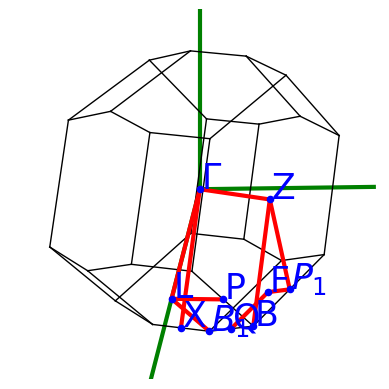

In [13]:
bsplotter.plot_brillouin()

## Identification des Branches Acoustiques près de Γ

Les branches acoustiques sont caractérisées par $f \to 0$ lorsque $q \to 0$ (point Γ). Le code suivant identifie les 3 premières branches (indices 0, 1, 2) qui satisfont cette condition au début ou à la fin d'un segment du chemin k, ainsi que les segments correspondants.

*Note : On s'attend à ce que les branches acoustiques soient les 3 plus basses en énergie (indices 0, 1, 2).* 

In [ ]:
data = bsplotter.bs_plot_data() 
dist = data.get("distances")
freq = data.get("frequency")

# La fonction `id_branches_acoustiques` identifie les branches acoustiques
# à partir des données de fréquences extraites de la relation de dispersion phononique.
#
# Paramètres :
# - freqs : Liste de listes contenant les fréquences des branches phononiques
#   pour chaque segment de la relation de dispersion.
#
# Retourne :
# - ac_freqs : Liste des fréquences des branches acoustiques identifiées.
# - br_indices : Liste des indices des branches acoustiques identifiées.
# - z_indices : Liste des indices des segments (zones) correspondants.
#
# La fonction parcourt chaque segment et chaque branche pour vérifier si la fréquence
# au début ou à la fin est nulle. Une fois les trois branches acoustiques identifiées,
# elle retourne les résultats.

def id_branches_acoustiques(freqs):
    ac_freqs, br_indices, z_indices = [], [], []

    for z_idx, seg_freqs in enumerate(freqs):
        for br_idx, br_freqs in enumerate(seg_freqs):
            if (br_freqs[0] == 0 or br_freqs[-1] == 0) and \
               br_idx not in br_indices and z_idx not in z_indices:
                z_indices.append(z_idx)
                br_indices.append(br_idx)
                ac_freqs.append(br_freqs)

            if len(br_indices) == 3:
                return ac_freqs, br_indices, z_indices

# Identifier les branches acoustiques à partir des fréquences
freqs_ac, idx_br, idx_zones = id_branches_acoustiques(freq)
print("Indices des branches acoustiques :", idx_br)

# Récupérer les labels des directions en k-espace
labels_kpts = [ph_bs.branches[i]["name"] for i in idx_zones]
print("Directions cristallographiques de ces branches acoustiques :", labels_kpts)


Indices des branches acoustiques : [0, 1, 2]
Directions cristallographiques de ces branches acoustiques : ['\\Gamma-L', 'Z-\\Gamma', '\\Gamma-X']


## Calcul et Visualisation des Vitesses du Son

Pour chaque branche acoustique identifiée, nous calculons la vitesse du son $v_s = 2\pi \times |df/dq|_{q \to 0}$ en effectuant un ajustement linéaire ($f = a \cdot q + b$) sur les deux premiers points de données près de $\Gamma$. La pente $a$ est utilisée pour calculer $v_s$ après conversion d'unités (THz/Å⁻¹ vers m/s).

Le graphique affiche les branches de phonons, met en évidence les 3 branches acoustiques analysées, et trace les droites correspondant aux ajustements linéaires près de $\Gamma$, dont les pentes donnent les vitesses du son.

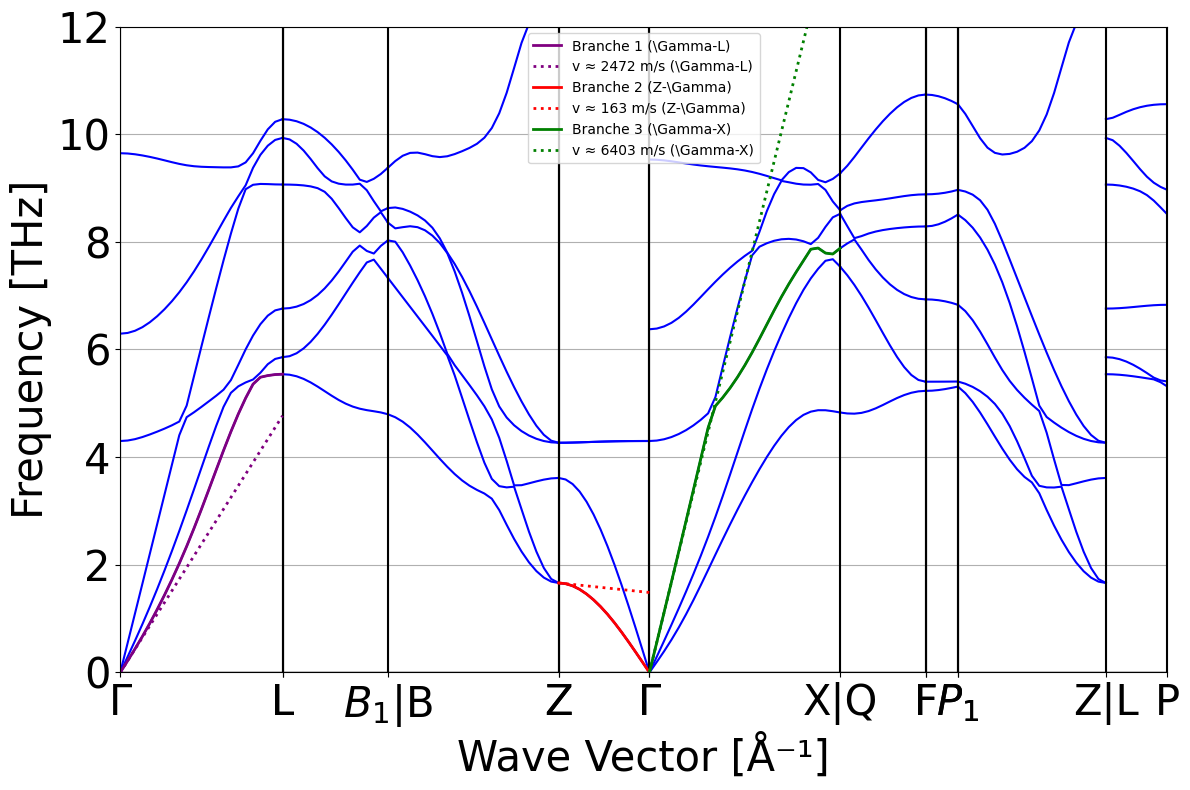

+-------------+-----------------+
| Direction   |   Vitesse (m/s) |
+=============+=================+
| \Gamma-L    |        2471.86  |
+-------------+-----------------+
| Z-\Gamma    |         163.472 |
+-------------+-----------------+
| \Gamma-X    |        6403.05  |
+-------------+-----------------+


In [19]:
# Récupération de la figure et initialisation
fig = bsplotter.get_plot()
ax = plt.gca()
couleurs, styles = ["purple", "red", "green"], ["-", "-", "-"]
resultats_vitesse = []

# Boucle sur les branches acoustiques
for i, (zone, branche, direction) in enumerate(zip(idx_zones, idx_br, labels_kpts)):
    # Récupération des données q (vecteur d'onde) et f (fréquence) pour la branche et la zone
    q_vals = dist[zone]
    f_vals = freq[zone][branche]

    # Sélection des deux premiers points pour effectuer un ajustement linéaire
    q_subset = np.array(q_vals[:2])
    f_subset = np.array(f_vals[:2])

    # Ajustement linéaire pour calculer la pente (df/dq)
    coeffs = np.polyfit(q_subset, f_subset, 1)

    # Calcul de la vitesse du son (conversion des unités de THz/Å⁻¹ à m/s)
    v_son = abs(coeffs[0] * 2 * np.pi * 1e12 * 1e-10)

    # Tracé des données de la branche acoustique (courbe de dispersion)
    ax.plot(
        q_vals, f_vals,
        color=couleurs[i], lw=2, linestyle=styles[i],
        label=f"Branche {i+1} ({direction})"
    )

    # Tracé de la droite d'ajustement linéaire pour visualiser la pente près de Γ
    q_fit = np.linspace(q_vals[0], q_vals[-1], 500)
    f_fit = coeffs[0] * q_fit + coeffs[1]
    ax.plot(
        q_fit, f_fit,
        color=couleurs[i], lw=2, linestyle="dotted",
        label=f"v ≈ {v_son:.0f} m/s ({direction})"
    )

    # Stockage des résultats pour affichage ultérieur dans un tableau
    resultats_vitesse.append((direction, v_son))

# Mise en forme du graphique
ax.set(xlabel="Wave Vector [Å⁻¹]", ylabel="Frequency [THz]", ylim=(0, 12))
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# Affichage des résultats
print(tabulate(resultats_vitesse, headers=["Direction", "Vitesse (m/s)"], tablefmt="grid"))


## Analyse des Résultats

Le graphique et le tableau ci-dessus présentent les vitesses du son calculées pour les branches acoustiques de LiRhO₂ le long de trois directions distinctes émanant de ou pointant vers Γ.

**Interprétation :**

1.  **Forte Anisotropie :** La vitesse du son varie considérablement selon la direction de propagation. C'est le résultat le plus marquant. La vitesse est environ 40 fois plus élevée le long de Γ-X que le long de Z-Γ.
2.  **Rigidité Directionnelle :** Cette anisotropie reflète directement l'anisotropie des constantes élastiques du matériau. LiRhO₂ est beaucoup plus "rigide" (résistant à la déformation par une onde de compression/cisaillement) le long de la direction Γ-X que le long de Z-Γ.
3.  **Vitesse Extrêmement Basse (Z-Γ) :** La valeur de ~163 m/s est très faible pour un solide. Cela peut indiquer la présence d'un mode vibrationnel particulièrement "mou" (basse fréquence pour un q donné) dans cette direction. De tels modes mous peuvent parfois être précurseurs d'instabilités structurales ou de transitions de phase, ou simplement refléter des liaisons faibles ou des mécanismes de vibration spécifiques dans cette direction.
4.  **Vitesse Élevée (Γ-X) :** La valeur de ~6400 m/s est relativement élevée, suggérant des liaisons interatomiques fortes et efficaces pour transmettre les vibrations dans cette direction.


## Conclusion

Nous avons calculé les vitesses du son pour trois branches acoustiques de LiRhO₂ (mp-14115) le long des directions Γ-L, Z-Γ et Γ-X. L'approximation linéaire de la dispersion $f(q)$ près de Γ a permis d'extraire les pentes $df/dq$ et de calculer les vitesses.

Le résultat principal est la **forte anisotropie** des propriétés élastiques dynamiques de LiRhO₂, avec des vitesses du son variant de ~163 m/s (Z-Γ) à ~6403 m/s (Γ-X). Cette différence marquée souligne l'importance de considérer la directionnalité lors de l'étude des propriétés mécaniques et thermiques (comme la conductivité thermique du réseau) de ce matériau.